# Данные 
В некотором *городе N* на каждом автобусе/троллейбусе/трамвае установлены GPS трекеры, которые с некоторым промежутком времени передают информацию о своем местоположении на специальный сервер. 

Данные для всех транспортных средства одного маршрута непрерывно записывались на протяжении недели, потом GPS координаты (широта и долгота) были спроецированы на плоскость с использованием [проекции Меркатора](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_%D0%9C%D0%B5%D1%80%D0%BA%D0%B0%D1%82%D0%BE%D1%80%D0%B0) и некоторого линейного преобразования. Эти данные записаны в файле **../data/transport_log.zip** в виде:

>    **1447037729**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**3054.619968**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**2409.828279**&nbsp;&nbsp;&lt;tab&gt;&nbsp;&nbsp;**570d8**

поля разделены табуляцией. Здесь:
- **1447037729** - [UNIX-время](https://ru.wikipedia.org/wiki/UNIX-%D0%B2%D1%80%D0%B5%D0%BC%D1%8F), которое без труда можно преобразовать во что-то разумное с помощью стандартной библиотеки [Python](https://docs.python.org/2/library/datetime.html#datetime.date.fromtimestamp).
- **3054.619968** - координата "x"
- **2409.828279** - координата "y"
- **570d8** - уникальный идентификатор транспортного средства, от которого получен сигнал. 

Маршрут автобосов "туда" не совпадает с маршрутом "обратно". Известно, что в направлении, которое мы назовем "туда"  первая остановка имеет координаты:

>   **(11038.08464497, 8253.17542416)**

последняя:

>   **(283.08479678,  163.45489494)**


# Задачи

- Отобразить все точки на плоскости

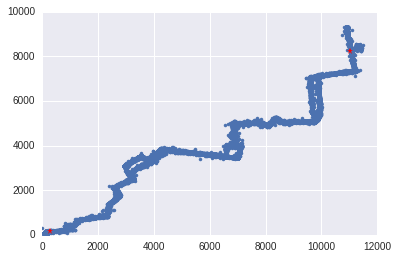

In [153]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import zipfile

%matplotlib inline

archive = zipfile.ZipFile('transport_log.zip', 'r')
file = archive.open('transport_log.txt')

df = pd.read_table(file, header=None)
x = list(df[1])
y = list(df[2])
plt.plot(x,y, '.')
plt.plot(11038.08464497, 8253.17542416,'*', c='r')
plt.plot(283.08479678, 163.45489494,'*', c='r')

plt.show()

- Отобразить в bar plot зависимость числа точек от часа (0-23). По оси "X" столбцы с метками 0-23, по оси "Y" - число соответствующих точек в логе.

<Container object of 24 artists>

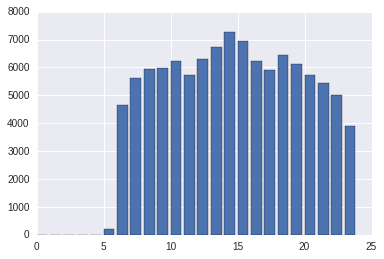

In [154]:
import datetime

h = [datetime.datetime.fromtimestamp(i).time().hour for i in list(df[0])]
point_in_hour = [(len(list(filter(lambda x: x==i, h)))) for i in range(24)]
plt.bar(range(24), point_in_hour)

- Выделить из лога подпоследовательности, соответствующие гарантировано полным маршрутам в направлении "туда". То есть автобус должен пройти первую остановку с обозначенными выше координатами, затем последнюю.

<function __main__.func>

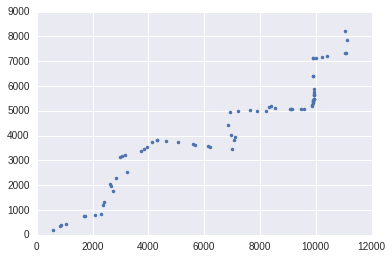

In [155]:
import ipywidgets
import numpy as np
from ipywidgets import interact


def find_route(s, e, routes):
    for i in s:
        j = e[np.argmax(e>i)]
        route = sub[i:j]
        routes.append(route)
        
    
# start = (11038.08464497, 8253.17542416)
# finish = (283.08479678, 163.45489494)
buses = set(df[3])
routes = []
for bus in buses:
    sub = df[df[3]==bus]
    s = np.where((sub[2]<8255) & (sub[2]>8200))[0]
    e = np.where(sub[1]<284)[0] 
    find_route(s, e, routes)
    
num_routes = len(routes)


def func(a):
    plt.plot(list(routes[a][1]), list(routes[a][2]), '.')

interact(func, a=ipywidgets.IntSlider(min=0,max=num_routes-1,step=1))


- По данным из предыдущего пункта построить приближенный маршрут в виде кусочно-линейно функции, причем линейные компоненты должны иметь одинаковую длину. Отобразить таким образом, чтобы каждый участок имел цвет в зависимости от средней скорости прохождения участка. 

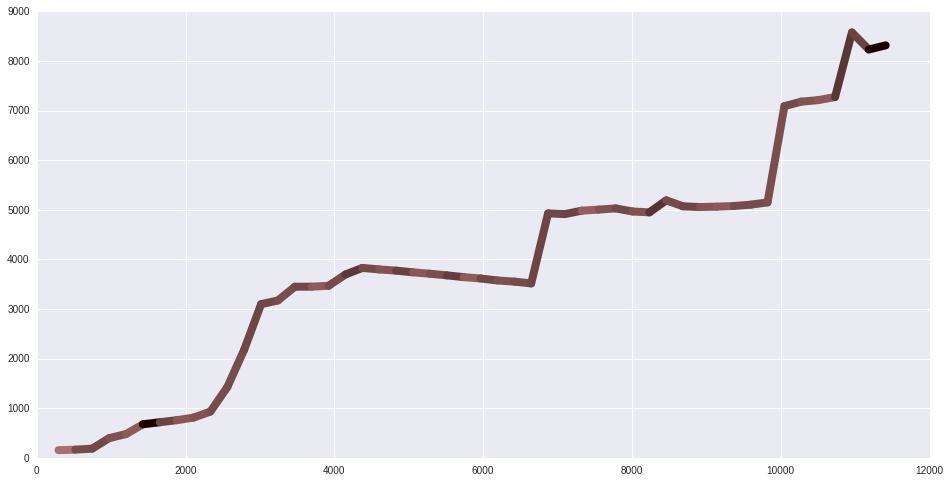

In [156]:
import math as m
import matplotlib
from matplotlib.colors import colorConverter
import matplotlib.cm as cm

plt.figure(figsize=(16,8))


all_routes = pd.concat(routes)

max_x = all_routes[all_routes[1]>11400][1].mean()
min_x = all_routes[all_routes[1]<300][1].mean()
max_y = all_routes[all_routes[1]>11400][2].mean()
min_y = all_routes[all_routes[1]<300][2].mean()

n = 50   #к-во отрезков
x = np.linspace(min_x, max_x, n)

speeds = []

avr_speeds = [] #средние скорости на отрезках
y = []
avr_y = []
avr_y.append(min_y)

#на каждом отрезке из скоростей всех маршрутов получаем среднюю скорость
for i in range(len(x)-1):
    x1 = x[i]
    x2 = x[i+1]
    for route in routes:
        sub = route[(route[1]>x1) & (route[1]<x2)]
        if len(sub)<2:
            continue
        time = sub.iloc[-1][0]-sub.iloc[0][0]
        dist = m.sqrt((sub.iloc[-1][1]-sub.iloc[0][1])**2 + (sub.iloc[-1][2]-sub.iloc[0][2])**2)
        speeds.append(dist/time)
        if i!=len(x)-2:
            y.append(sub.iloc[0][2])
    avr_speeds.append(sum(speeds)/len(speeds))
    speeds = []
    if i!=len(x)-2:
        avr_y.append(sum(y)/len(y))
        y = []
avr_y.append(max_y)

norm_speeds = avr_speeds / np.linalg.norm(avr_speeds)  

for i in range(len(x)-1):
    c = cm.pink(norm_speeds[i])
    plt.plot([x[i],x[i+1]], [avr_y[i],avr_y[i+1]], color = c, linewidth=8)



Не хватает colorbar, не смогла найти, как его добавить для моего графика